In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import ttest_ind
import ast
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
import numba
import seaborn as sns
from statannotations.Annotator import Annotator
import iqplot
from sklearn import metrics
import bokeh.models
import bokeh.plotting
import bokeh.io
bokeh.io.output_notebook()

Loading BokehJS ...

In [2]:
df_tex2 = pd.read_csv('data/Heterophilic/TexasBetaRandomSeedConsistancy.csv')
df_tex4 = pd.read_csv('data/Heterophilic/TexasGNNRandomSeedConsistancy.csv')
df_wis2 = pd.read_csv('data/Heterophilic/WisconsinBetaRandomSeedConsistancy.csv')
df_wis4 = pd.read_csv('data/Heterophilic/WisconsinGNNRandomSeedConsistancy.csv')
frames = [df_tex2, df_tex4, df_wis2, df_wis4]
df_het_fid = pd.concat(frames)
df_het_fid = df_het_fid.rename(columns={'Phen Pos Fidelity':'Positive Phenomenon Fidelity',
                                        'Phen Neg Fidelity':'Negative Phenomenon Fidelity',
                                        'Model Pos Fidelity':'Positive Model Fidelity',
                                        'Model Neg Fidelity':'Negative Model Fidelity',
                                        'Exp Size Percent':'Fraction of Edges in Explanation'
                                       })
wp = 0.5
wn = 0.5
df_het_fid['Num'] = (wp + wn) * df_het_fid['Positive Phenomenon Fidelity'] * (1 - df_het_fid['Negative Phenomenon Fidelity'])
df_het_fid['Denom'] = wp * (1 - df_het_fid['Negative Phenomenon Fidelity']) + wn * df_het_fid['Positive Phenomenon Fidelity']
df_het_fid['Phenomenon Characterization Score'] = df_het_fid['Num'] / df_het_fid['Denom']
df_het_fid['Num'] = (wp + wn) * df_het_fid['Positive Model Fidelity'] * (1 - df_het_fid['Negative Model Fidelity'])
df_het_fid['Denom'] = wp * (1 - df_het_fid['Negative Model Fidelity']) + wn * df_het_fid['Positive Model Fidelity']
df_het_fid['Model Characterization Score'] = df_het_fid['Num'] / df_het_fid['Denom']
df_het_fid.head()

,Dataset,Explainer,Seed,Positive Phenomenon Fidelity,Negative Phenomenon Fidelity,Positive Model Fidelity,Negative Model Fidelity,Unfaithfulness,Fraction of Edges in Explanation,Unnamed: 0,Num,Denom,Phenomenon Characterization Score,Model Characterization Score
0,Texas,Beta,79691,0.032787,0.000000,0.038251,0.000000,1.000000,0.476923,NaN,0.038251,0.519126,0.063492,0.073684
1,Texas,Beta,19709,0.016393,0.021858,0.016393,0.027322,1.000000,0.507692,NaN,0.015946,0.494536,0.032246,0.032243
2,Texas,Beta,40177,0.016393,0.016393,0.016393,0.021858,1.000000,0.393846,NaN,0.016035,0.497268,0.032249,0.032246
3,Texas,Beta,36482,0.027322,0.000000,0.032787,0.000000,0.999998,0.516923,NaN,0.032787,0.516393,0.053191,0.063492
4,Texas,Beta,75011,0.021858,0.016393,0.021858,0.021858,1.000000,0.406154,NaN,0.021380,0.500000,0.042766,0.042760


In [3]:
df_cora2 = pd.read_csv('data/Cora/CoraBetaRandomSeedConsistancy.csv')
df_cora4 = pd.read_csv('data/Cora/CoraGNNRandomSeedConsistancy.csv')
df_cs2 = pd.read_csv('data/CiteSeer/CiteSeerBetaRandomSeedConsistancy.csv')
df_cs4 = pd.read_csv('data/CiteSeer/CiteSeerGNNRandomSeedConsistancy.csv')
frames = [df_cora2, df_cora4, df_cs2, df_cs4]
df_sp_fid = pd.concat(frames)
df_sp_fid = df_sp_fid.rename(columns={'Phen Pos Fidelity':'Positive Phenomenon Fidelity',
                                        'Phen Neg Fidelity':'Negative Phenomenon Fidelity',
                                        'Model Pos Fidelity':'Positive Model Fidelity',
                                        'Model Neg Fidelity':'Negative Model Fidelity',
                                        'Exp Size Percent':'Fraction of Edges in Explanation'
                                       })
wp = 0.5
wn = 0.5
df_sp_fid['Num'] = (wp + wn) * df_sp_fid['Positive Phenomenon Fidelity'] * (1 - df_sp_fid['Negative Phenomenon Fidelity'])
df_sp_fid['Denom'] = wp * (1 - df_sp_fid['Negative Phenomenon Fidelity']) + wn * df_sp_fid['Positive Phenomenon Fidelity']
df_sp_fid['Phenomenon Characterization Score'] = df_sp_fid['Num'] / df_sp_fid['Denom']
df_sp_fid['Num'] = (wp + wn) * df_sp_fid['Positive Model Fidelity'] * (1 - df_sp_fid['Negative Model Fidelity'])
df_sp_fid['Denom'] = wp * (1 - df_sp_fid['Negative Model Fidelity']) + wn * df_sp_fid['Positive Model Fidelity']
df_sp_fid['Model Characterization Score'] = df_sp_fid['Num'] / df_sp_fid['Denom']
df_sp_fid.head()

,Dataset,Explainer,Seed,Positive Phenomenon Fidelity,Negative Phenomenon Fidelity,Positive Model Fidelity,Negative Model Fidelity,Unfaithfulness,Fraction of Edges in Explanation,Unnamed: 0,Num,Denom,Phenomenon Characterization Score,Model Characterization Score
0,Cora,Beta,68268,0.089734,0.092319,0.093427,0.097120,1.0,0.513357,NaN,0.084353,0.498154,0.163322,0.169332
1,Cora,Beta,43567,0.086780,0.096012,0.091950,0.098597,1.0,0.518283,NaN,0.082884,0.496677,0.158358,0.166877
2,Cora,Beta,42613,0.095643,0.080871,0.098966,0.086780,1.0,0.517526,NaN,0.090378,0.506093,0.173256,0.178579
3,Cora,Beta,45891,0.088257,0.093796,0.091581,0.097120,1.0,0.510136,NaN,0.082686,0.497230,0.160849,0.166294
4,Cora,Beta,21243,0.086780,0.087518,0.091581,0.091211,1.0,0.521599,NaN,0.083227,0.500185,0.158487,0.166393


In [4]:
df_s25_2 = pd.read_csv('data/SERGIO/SeedConsistancySERGIO25beta.csv')
df_s25_4 = pd.read_csv('data/SERGIO/SeedConsistancySERGIO25gnn.csv')
df_s50_2 = pd.read_csv('data/SERGIO/SeedConsistancySERGIO50beta.csv')
df_s50_4 = pd.read_csv('data/SERGIO/SeedConsistancySERGIO50gnn.csv')
frames = [df_s25_2, df_s25_4, df_s50_2, df_s50_4]
df_sergio = pd.concat(frames)
df_sergio['Explainer'] = df_sergio['Explainer'].apply({'gnn':'GNN', 'beta':'Beta','GNN':'GNN','Beta':'Beta'}.get)
df_sergio['F1 Score'] = (2 * df_sergio['Torch Precision'] * df_sergio['Torch Recall']) / (df_sergio['Torch Precision'] + df_sergio['Torch Recall'])
df_sergio['Full F1 Score'] = (2 * df_sergio['Precision'] * df_sergio['Recall']) / (df_sergio['Precision'] + df_sergio['Recall'])
df_sergio = df_sergio.rename(columns={'Accuracy': 'Full Accuracy', 'Precision': 'Full Precision', 'Recall': 'Full Recall'})
df_sergio = df_sergio.rename(columns={'Torch Accuracy':'Accuracy','Torch Recall':
                                      'Recall','Torch Precision':'Precision', 'Faithfulness':'Unfaithfulness'})
df_sergio = df_sergio.fillna(0)
df_sergio['Dataset'] = df_sergio['Dataset'].apply({25:'25% Sparsity', 50:'50% Sparsity'}.get)
df_sergio.head()

,Unnamed: 0,Dataset,Seed,Explainer,TP,TN,FP,FN,Accuracy,Recall,Precision,Unfaithfulness,Full Accuracy,Full Precision,Full Recall,F1 Score,Full F1 Score
0,0,25% Sparsity,11591,Beta,32,115,3,105,0.98,1.0,0.914286,1.0,0.576471,0.914286,0.233577,0.955224,0.372093
1,1,25% Sparsity,64218,Beta,32,115,3,105,0.98,1.0,0.914286,1.0,0.576471,0.914286,0.233577,0.955224,0.372093
2,2,25% Sparsity,46540,Beta,32,115,3,105,0.98,1.0,0.914286,1.0,0.576471,0.914286,0.233577,0.955224,0.372093
3,3,25% Sparsity,44133,Beta,32,115,3,105,0.98,1.0,0.914286,1.0,0.576471,0.914286,0.233577,0.955224,0.372093
4,4,25% Sparsity,16650,Beta,32,115,3,105,0.98,1.0,0.914286,1.0,0.576471,0.914286,0.233577,0.955224,0.372093


In [5]:
df_base2 = pd.read_csv('data/xAI/baseBetaExpxAISeedResults.csv')
df_base4 = pd.read_csv('data/xAI/baseGNNExpxAISeedResults.csv')
df_base2['Explainer'] = 'Beta'
df_base4['Explainer'] = 'GNN'
frames = [df_base2,df_base4]
df_base = pd.concat(frames)
df_base['Dataset'] = 'SG-BASE'
df_hetero2 = pd.read_csv('data/xAI/heteroBetaExpxAISeedResults.csv')
df_hetero4 = pd.read_csv('data/xAI/heteroGNNExpxAISeedResults.csv')
df_hetero2['Explainer'] = 'Beta'
df_hetero4['Explainer'] = 'GNN'
frames = [df_hetero2,df_hetero4]
df_hetero = pd.concat(frames)
df_hetero['Dataset'] = 'SG-HETEROPHILIC'
df_unfair2 = pd.read_csv('data/xAI/unfairBetaExpxAISeedResults.csv')
df_unfair4 = pd.read_csv('data/xAI/unfairGNNExpxAISeedResults.csv')
df_unfair2['Explainer'] = 'Beta'
df_unfair4['Explainer'] = 'GNN'
frames = [df_unfair2,df_unfair4]
df_unfair = pd.concat(frames)
df_unfair['Dataset'] = 'SG-UNFAIR'
df_less2 = pd.read_csv('data/xAI/lessinformBetaExpxAISeedResults.csv')
df_less4 = pd.read_csv('data/xAI/lessinformGNNExpxAISeedResults.csv')
df_less2['Explainer'] = 'Beta'
df_less4['Explainer'] = 'GNN'
frames = [df_less2,df_less4]
df_less = pd.concat(frames)
df_less['Dataset'] = 'SG-LESSINFORM'
df_more2 = pd.read_csv('data/xAI/moreinformBetaExpxAISeedResults.csv')
df_more4 = pd.read_csv('data/xAI/moreinformGNNExpxAISeedResults.csv')
df_more2['Explainer'] = 'Beta'
df_more4['Explainer'] = 'GNN'
frames = [df_more2,df_more4]
df_more = pd.concat(frames)
df_more['Dataset'] = 'SG-MOREINFORM'
frames = [df_base,df_hetero,df_unfair,df_less,df_more]
df_xai = pd.concat(frames)
df_xai = df_xai.rename(columns={'Best Acc':'Accuracy','Best Faith':'Best Unfaithfulness', 'Avg Faith':'Average Unfaithfulness'})
df_xai['F1 Score'] = (2 * df_xai['Best Prec'] * df_xai['Best Rec']) / (df_xai['Best Prec'] + df_xai['Best Rec'])
df_xai.head()

,Avg Acc,Avg Prec,Avg Rec,Accuracy,Best Prec,Best Rec,Average Unfaithfulness,Best Unfaithfulness,Alpha,Beta,Seed,LR,IDX,Explainer,Dataset,F1 Score
0,0.231653,0.234579,0.955515,0.875000,0.875000,1.0,0.455461,-1.190000e-07,0.8,0.6,0,0.05,12859,Beta,SG-BASE,0.933333
1,0.231582,0.234472,0.956285,0.777778,0.777778,1.0,0.451796,-1.190000e-07,0.8,0.6,1,0.05,6080,Beta,SG-BASE,0.875000
2,0.231338,0.234445,0.953977,0.777778,0.777778,1.0,0.462795,-1.190000e-07,0.8,0.6,2,0.05,11180,Beta,SG-BASE,0.875000
3,0.231506,0.234472,0.955405,0.875000,0.875000,1.0,0.461058,-1.190000e-07,0.8,0.6,3,0.05,12859,Beta,SG-BASE,0.933333
4,0.231740,0.234652,0.955522,0.777778,0.777778,1.0,0.453390,8.331227e-02,0.8,0.6,4,0.05,13112,Beta,SG-BASE,0.875000


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

50% Sparsity_Beta vs. 50% Sparsity_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:7.543e-02 U_stat=2.650e+01
25% Sparsity_Beta vs. 25% Sparsity_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:2.428e-05 U_stat=1.000e+02


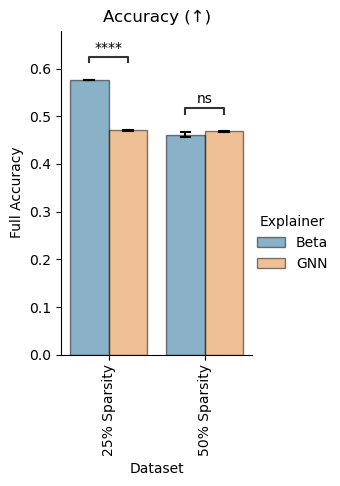

In [6]:
x = 'Dataset'
y = 'Full Accuracy'
hue = 'Explainer'
hue_order = ['Beta','GNN']
order = ['25% Sparsity', '50% Sparsity']
args = dict(x=x, y=y, data=df_sergio, hue=hue, hue_order=hue_order, order=order)
g = sns.catplot(edgecolor="black", errcolor="black", 
                errwidth=1.5, capsize = 0.1, height=4, 
                aspect=.7,alpha=0.5, kind="bar", errorbar = "se",
                **args
               ).set(title='Accuracy (↑)').set_xticklabels(rotation=90)
pairs = [
    (("25% Sparsity", "Beta"), ("25% Sparsity", "GNN")),
    (("50% Sparsity", "Beta"), ("50% Sparsity", "GNN"))
]
for ax_n in g.axes:
    for ax in ax_n:
        annot = Annotator(ax, pairs, **args)
        annot.configure(test='Mann-Whitney', loc='inside', verbose=2)
        annot.apply_test().annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

50% Sparsity_Beta vs. 50% Sparsity_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:1.598e-02 U_stat=8.200e+01
25% Sparsity_Beta vs. 25% Sparsity_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:2.428e-05 U_stat=1.000e+02


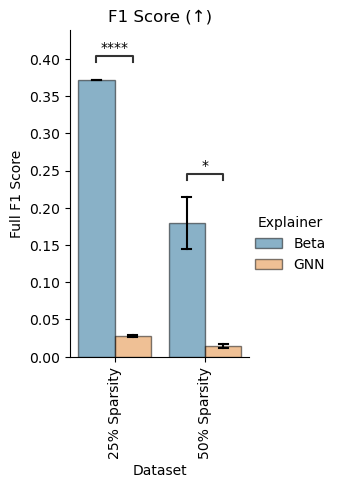

In [7]:
x = 'Dataset'
y = 'Full F1 Score'
hue = 'Explainer'
hue_order = ['Beta','GNN']
order = ['25% Sparsity', '50% Sparsity']
args = dict(x=x, y=y, data=df_sergio, hue=hue, hue_order=hue_order, order=order)
g = sns.catplot(edgecolor="black", errcolor="black", 
                errwidth=1.5, capsize = 0.1, height=4, 
                aspect=.7,alpha=0.5, kind="bar", errorbar = "se",
                **args
               ).set(title='F1 Score (↑)').set_xticklabels(rotation=90)
pairs = [
    (("25% Sparsity", "Beta"), ("25% Sparsity", "GNN")),
    (("50% Sparsity", "Beta"), ("50% Sparsity", "GNN"))
]
for ax_n in g.axes:
    for ax in ax_n:
        annot = Annotator(ax, pairs, **args)
        annot.configure(test='Mann-Whitney', loc='inside', verbose=2)
        annot.apply_test().annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

50% Sparsity_Beta vs. 50% Sparsity_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=5.000e+01
25% Sparsity_Beta vs. 25% Sparsity_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:1.594e-05 U_stat=0.000e+00


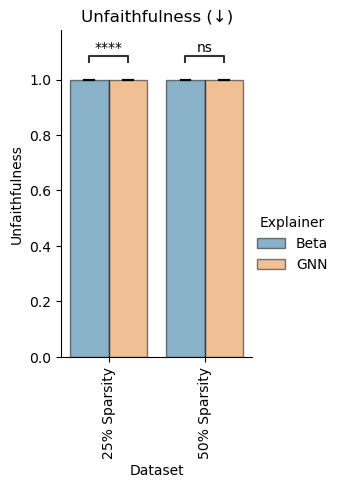

In [8]:
x = 'Dataset'
y = 'Unfaithfulness'
hue = 'Explainer'
hue_order = ['Beta','GNN']
order = ['25% Sparsity', '50% Sparsity']
args = dict(x=x, y=y, data=df_sergio, hue=hue, hue_order=hue_order, order=order)
g = sns.catplot(edgecolor="black", errcolor="black", 
                errwidth=1.5, capsize = 0.1, height=4, 
                aspect=.7,alpha=0.5, kind="bar", errorbar = "se",
                **args
               ).set(title='Unfaithfulness (↓)').set_xticklabels(rotation=90)
pairs = [
    (("25% Sparsity", "Beta"), ("25% Sparsity", "GNN")),
    (("50% Sparsity", "Beta"), ("50% Sparsity", "GNN"))
]
for ax_n in g.axes:
    for ax in ax_n:
        annot = Annotator(ax, pairs, **args)
        annot.configure(test='Mann-Whitney', loc='inside', verbose=2)
        annot.apply_test().annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

50% Sparsity_Beta vs. 50% Sparsity_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:7.543e-02 U_stat=2.650e+01
25% Sparsity_Beta vs. 25% Sparsity_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:2.428e-05 U_stat=1.000e+02


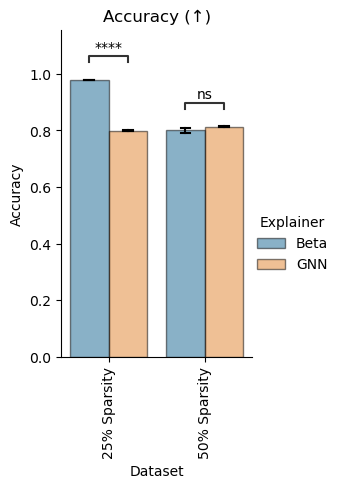

In [9]:
x = 'Dataset'
y = 'Accuracy'
hue = 'Explainer'
hue_order = ['Beta','GNN']
order = ['25% Sparsity', '50% Sparsity']
args = dict(x=x, y=y, data=df_sergio, hue=hue, hue_order=hue_order, order=order)
g = sns.catplot(edgecolor="black", errcolor="black", 
                errwidth=1.5, capsize = 0.1, height=4, 
                aspect=.7,alpha=0.5, kind="bar", errorbar = "se",
                **args
               ).set(title='Accuracy (↑)').set_xticklabels(rotation=90)
pairs = [
    (("25% Sparsity", "Beta"), ("25% Sparsity", "GNN")),
    (("50% Sparsity", "Beta"), ("50% Sparsity", "GNN"))
]
for ax_n in g.axes:
    for ax in ax_n:
        annot = Annotator(ax, pairs, **args)
        annot.configure(test='Mann-Whitney', loc='inside', verbose=2)
        annot.apply_test().annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

50% Sparsity_Beta vs. 50% Sparsity_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:1.598e-02 U_stat=8.200e+01
25% Sparsity_Beta vs. 25% Sparsity_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:2.428e-05 U_stat=1.000e+02


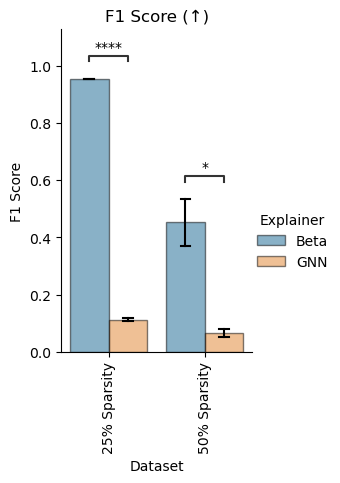

In [10]:
x = 'Dataset'
y = 'F1 Score'
hue = 'Explainer'
hue_order = ['Beta','GNN']
order = ['25% Sparsity', '50% Sparsity']
args = dict(x=x, y=y, data=df_sergio, hue=hue, hue_order=hue_order, order=order)
g = sns.catplot(edgecolor="black", errcolor="black", 
                errwidth=1.5, capsize = 0.1, height=4, 
                aspect=.7,alpha=0.5, kind="bar", errorbar = "se",
                **args
               ).set(title='F1 Score (↑)').set_xticklabels(rotation=90)
pairs = [
    (("25% Sparsity", "Beta"), ("25% Sparsity", "GNN")),
    (("50% Sparsity", "Beta"), ("50% Sparsity", "GNN"))
]
for ax_n in g.axes:
    for ax in ax_n:
        annot = Annotator(ax, pairs, **args)
        annot.configure(test='Mann-Whitney', loc='inside', verbose=2)
        annot.apply_test().annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Wisconsin_Beta vs. Wisconsin_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:2.051e-02 U_stat=8.100e+01
Texas_Beta vs. Texas_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:8.201e-01 U_stat=5.350e+01


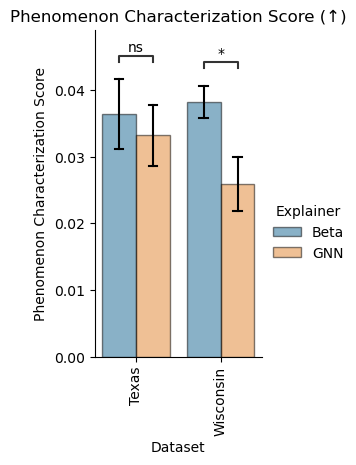

In [11]:
x = 'Dataset'
y = 'Phenomenon Characterization Score'
hue = 'Explainer'
hue_order = ['Beta','GNN']
order = ['Texas', 'Wisconsin']
args = dict(x=x, y=y, data=df_het_fid, hue=hue, hue_order=hue_order, order=order)
g = sns.catplot(edgecolor="black", errcolor="black", 
                errwidth=1.5, capsize = 0.1, height=4, 
                aspect=.7,alpha=0.5, kind="bar", errorbar = "se",
                **args
               ).set(title='Phenomenon Characterization Score (↑)').set_xticklabels(rotation=90)
pairs = [
    (("Texas", "Beta"), ("Texas", "GNN")),
    (("Wisconsin", "Beta"), ("Wisconsin", "GNN"))
]
for ax_n in g.axes:
    for ax in ax_n:
        annot = Annotator(ax, pairs, **args)
        annot.configure(test='Mann-Whitney', loc='inside', verbose=2)
        annot.apply_test().annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Wisconsin_Beta vs. Wisconsin_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:2.760e-02 U_stat=7.950e+01
Texas_Beta vs. Texas_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:8.795e-01 U_stat=4.750e+01


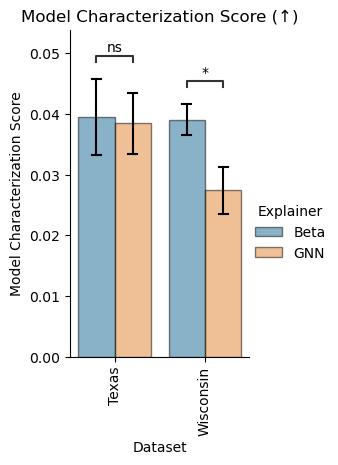

In [12]:
x = 'Dataset'
y = 'Model Characterization Score'
hue = 'Explainer'
hue_order = ['Beta','GNN']
order = ['Texas', 'Wisconsin']
args = dict(x=x, y=y, data=df_het_fid, hue=hue, hue_order=hue_order, order=order)
g = sns.catplot(edgecolor="black", errcolor="black", 
                errwidth=1.5, capsize = 0.1, height=4, 
                aspect=.7,alpha=0.5, kind="bar", errorbar = "se",
                **args
               ).set(title='Model Characterization Score (↑)').set_xticklabels(rotation=90)
pairs = [
    (("Texas", "Beta"), ("Texas", "GNN")),
    (("Wisconsin", "Beta"), ("Wisconsin", "GNN"))
]
for ax_n in g.axes:
    for ax in ax_n:
        annot = Annotator(ax, pairs, **args)
        annot.configure(test='Mann-Whitney', loc='inside', verbose=2)
        annot.apply_test().annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Wisconsin_Beta vs. Wisconsin_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:2.516e-02 U_stat=7.950e+01
Texas_Beta vs. Texas_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:8.764e-01 U_stat=5.250e+01


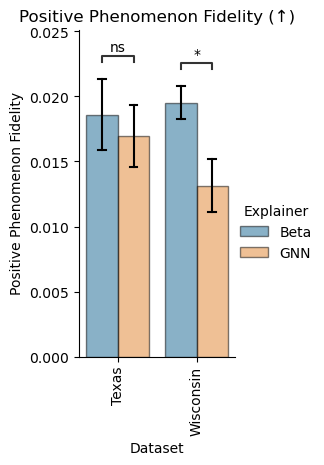

In [13]:
x = 'Dataset'
y = 'Positive Phenomenon Fidelity'
hue = 'Explainer'
hue_order = ['Beta','GNN']
order = ['Texas', 'Wisconsin']
args = dict(x=x, y=y, data=df_het_fid, hue=hue, hue_order=hue_order, order=order)
g = sns.catplot(edgecolor="black", errcolor="black", 
                errwidth=1.5, capsize = 0.1, height=4, 
                aspect=.7,alpha=0.5, kind="bar", errorbar = "se",
                **args
               ).set(title='Positive Phenomenon Fidelity (↑)').set_xticklabels(rotation=90)
pairs = [
    (("Texas", "Beta"), ("Texas", "GNN")),
    (("Wisconsin", "Beta"), ("Wisconsin", "GNN"))
]
for ax_n in g.axes:
    for ax in ax_n:
        annot = Annotator(ax, pairs, **args)
        annot.configure(test='Mann-Whitney', loc='inside', verbose=2)
        annot.apply_test().annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Wisconsin_Beta vs. Wisconsin_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:2.870e-02 U_stat=2.200e+01
Texas_Beta vs. Texas_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:3.752e-01 U_stat=3.800e+01


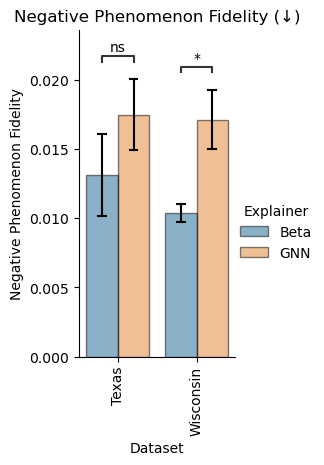

In [14]:
x = 'Dataset'
y = 'Negative Phenomenon Fidelity'
hue = 'Explainer'
hue_order = ['Beta','GNN']
order = ['Texas', 'Wisconsin']
args = dict(x=x, y=y, data=df_het_fid, hue=hue, hue_order=hue_order, order=order)
g = sns.catplot(edgecolor="black", errcolor="black", 
                errwidth=1.5, capsize = 0.1, height=4, 
                aspect=.7,alpha=0.5, kind="bar", errorbar = "se",
                **args
               ).set(title='Negative Phenomenon Fidelity (↓)').set_xticklabels(rotation=90)
pairs = [
    (("Texas", "Beta"), ("Texas", "GNN")),
    (("Wisconsin", "Beta"), ("Wisconsin", "GNN"))
]
for ax_n in g.axes:
    for ax in ax_n:
        annot = Annotator(ax, pairs, **args)
        annot.configure(test='Mann-Whitney', loc='inside', verbose=2)
        annot.apply_test().annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Wisconsin_Beta vs. Wisconsin_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:2.966e-02 U_stat=7.850e+01
Texas_Beta vs. Texas_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:8.775e-01 U_stat=4.750e+01


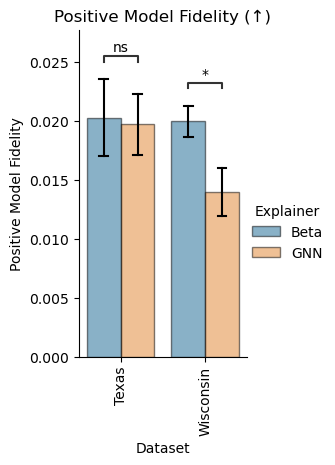

In [15]:
x = 'Dataset'
y = 'Positive Model Fidelity'
hue = 'Explainer'
hue_order = ['Beta','GNN']
order = ['Texas', 'Wisconsin']
args = dict(x=x, y=y, data=df_het_fid, hue=hue, hue_order=hue_order, order=order)
g = sns.catplot(edgecolor="black", errcolor="black", 
                errwidth=1.5, capsize = 0.1, height=4, 
                aspect=.7,alpha=0.5, kind="bar", errorbar = "se",
                **args
               ).set(title='Positive Model Fidelity (↑)').set_xticklabels(rotation=90)
pairs = [
    (("Texas", "Beta"), ("Texas", "GNN")),
    (("Wisconsin", "Beta"), ("Wisconsin", "GNN"))
]
for ax_n in g.axes:
    for ax in ax_n:
        annot = Annotator(ax, pairs, **args)
        annot.configure(test='Mann-Whitney', loc='inside', verbose=2)
        annot.apply_test().annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Wisconsin_Beta vs. Wisconsin_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:3.725e-02 U_stat=2.300e+01
Texas_Beta vs. Texas_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:6.436e-01 U_stat=4.350e+01


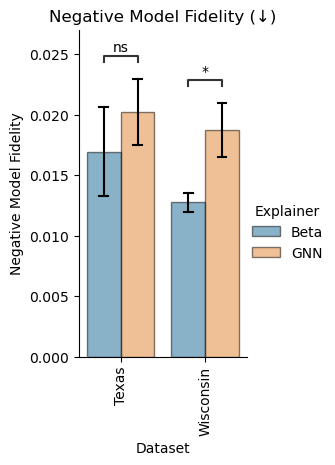

In [16]:
x = 'Dataset'
y = 'Negative Model Fidelity'
hue = 'Explainer'
hue_order = ['Beta','GNN']
order = ['Texas', 'Wisconsin']
args = dict(x=x, y=y, data=df_het_fid, hue=hue, hue_order=hue_order, order=order)
g = sns.catplot(edgecolor="black", errcolor="black", 
                errwidth=1.5, capsize = 0.1, height=4, 
                aspect=.7,alpha=0.5, kind="bar", errorbar = "se",
                **args
               ).set(title='Negative Model Fidelity (↓)').set_xticklabels(rotation=90)
pairs = [
    (("Texas", "Beta"), ("Texas", "GNN")),
    (("Wisconsin", "Beta"), ("Wisconsin", "GNN"))
]
for ax_n in g.axes:
    for ax in ax_n:
        annot = Annotator(ax, pairs, **args)
        annot.configure(test='Mann-Whitney', loc='inside', verbose=2)
        annot.apply_test().annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Wisconsin_Beta vs. Wisconsin_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:9.397e-01 U_stat=5.150e+01
Texas_Beta vs. Texas_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:8.187e-02 U_stat=7.350e+01


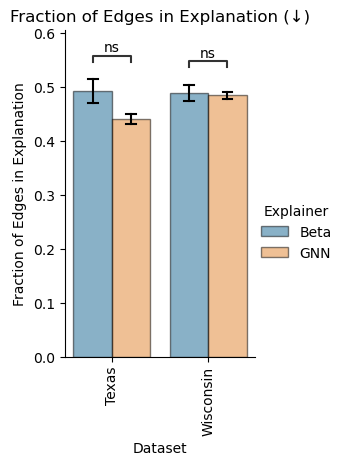

In [17]:
x = 'Dataset'
y = 'Fraction of Edges in Explanation'
hue = 'Explainer'
hue_order = ['Beta','GNN']
order = ['Texas', 'Wisconsin']
args = dict(x=x, y=y, data=df_het_fid, hue=hue, hue_order=hue_order, order=order)
g = sns.catplot(edgecolor="black", errcolor="black", 
                errwidth=1.5, capsize = 0.1, height=4, 
                aspect=.7,alpha=0.5, kind="bar", errorbar = "se",
                **args
               ).set(title='Fraction of Edges in Explanation (↓)').set_xticklabels(rotation=90)
pairs = [
    (("Texas", "Beta"), ("Texas", "GNN")),
    (("Wisconsin", "Beta"), ("Wisconsin", "GNN"))
]
for ax_n in g.axes:
    for ax in ax_n:
        annot = Annotator(ax, pairs, **args)
        annot.configure(test='Mann-Whitney', loc='inside', verbose=2)
        annot.apply_test().annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Wisconsin_Beta vs. Wisconsin_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:7.285e-03 U_stat=1.400e+01
Texas_Beta vs. Texas_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:3.108e-02 U_stat=2.100e+01


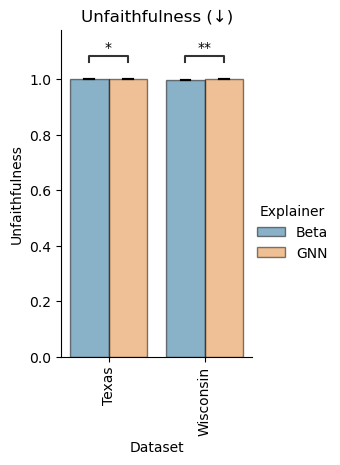

In [18]:
x = 'Dataset'
y = 'Unfaithfulness'
hue = 'Explainer'
hue_order = ['Beta','GNN']
order = ['Texas', 'Wisconsin']
args = dict(x=x, y=y, data=df_het_fid, hue=hue, hue_order=hue_order, order=order)
g = sns.catplot(edgecolor="black", errcolor="black", 
                errwidth=1.5, capsize = 0.1, height=4, 
                aspect=.7,alpha=0.5, kind="bar", errorbar = "se",
                **args
               ).set(title='Unfaithfulness (↓)').set_xticklabels(rotation=90)
pairs = [
    (("Texas", "Beta"), ("Texas", "GNN")),
    (("Wisconsin", "Beta"), ("Wisconsin", "GNN"))
]
for ax_n in g.axes:
    for ax in ax_n:
        annot = Annotator(ax, pairs, **args)
        annot.configure(test='Mann-Whitney', loc='inside', verbose=2)
        annot.apply_test().annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CiteSeer_Beta vs. CiteSeer_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=5.000e+01
Cora_Beta vs. Cora_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:1.859e-01 U_stat=6.800e+01


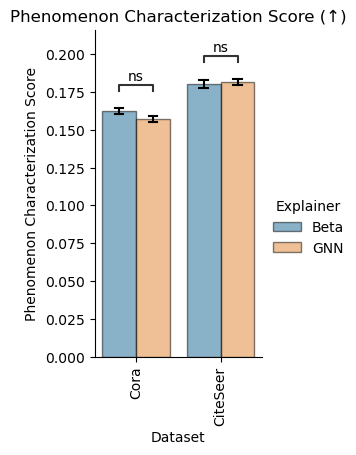

In [19]:
x = 'Dataset'
y = 'Phenomenon Characterization Score'
hue = 'Explainer'
hue_order = ['Beta','GNN']
order = ['Cora', 'CiteSeer']
args = dict(x=x, y=y, data=df_sp_fid, hue=hue, hue_order=hue_order, order=order)
g = sns.catplot(edgecolor="black", errcolor="black", 
                errwidth=1.5, capsize = 0.1, height=4, 
                aspect=.7,alpha=0.5, kind="bar", errorbar = "se",
                **args
               ).set(title='Phenomenon Characterization Score (↑)').set_xticklabels(rotation=90)
pairs = [
    (("Cora", "Beta"), ("Cora", "GNN")),
    (("CiteSeer", "Beta"), ("CiteSeer", "GNN"))
]
for ax_n in g.axes:
    for ax in ax_n:
        annot = Annotator(ax, pairs, **args)
        annot.configure(test='Mann-Whitney', loc='inside', verbose=2)
        annot.apply_test().annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CiteSeer_Beta vs. CiteSeer_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=5.000e+01
Cora_Beta vs. Cora_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:1.212e-01 U_stat=7.100e+01


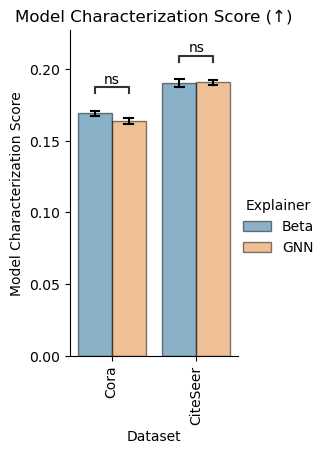

In [20]:
x = 'Dataset'
y = 'Model Characterization Score'
hue = 'Explainer'
hue_order = ['Beta','GNN']
order = ['Cora', 'CiteSeer']
args = dict(x=x, y=y, data=df_sp_fid, hue=hue, hue_order=hue_order, order=order)
g = sns.catplot(edgecolor="black", errcolor="black", 
                errwidth=1.5, capsize = 0.1, height=4, 
                aspect=.7,alpha=0.5, kind="bar", errorbar = "se",
                **args
               ).set(title='Model Characterization Score (↑)').set_xticklabels(rotation=90)
pairs = [
    (("Cora", "Beta"), ("Cora", "GNN")),
    (("CiteSeer", "Beta"), ("CiteSeer", "GNN"))
]
for ax_n in g.axes:
    for ax in ax_n:
        annot = Annotator(ax, pairs, **args)
        annot.configure(test='Mann-Whitney', loc='inside', verbose=2)
        annot.apply_test().annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CiteSeer_Beta vs. CiteSeer_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:9.096e-01 U_stat=5.200e+01
Cora_Beta vs. Cora_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:1.615e-01 U_stat=6.900e+01


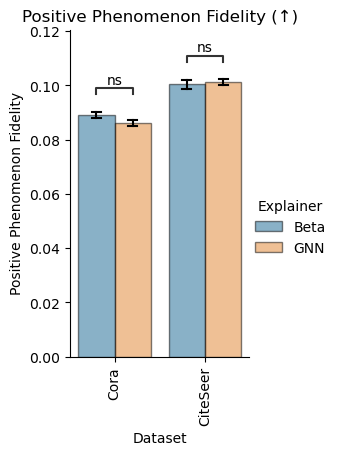

In [21]:
x = 'Dataset'
y = 'Positive Phenomenon Fidelity'
hue = 'Explainer'
hue_order = ['Beta','GNN']
order = ['Cora', 'CiteSeer']
args = dict(x=x, y=y, data=df_sp_fid, hue=hue, hue_order=hue_order, order=order)
g = sns.catplot(edgecolor="black", errcolor="black", 
                errwidth=1.5, capsize = 0.1, height=4, 
                aspect=.7,alpha=0.5, kind="bar", errorbar = "se",
                **args
               ).set(title='Positive Phenomenon Fidelity (↑)').set_xticklabels(rotation=90)
pairs = [
    (("Cora", "Beta"), ("Cora", "GNN")),
    (("CiteSeer", "Beta"), ("CiteSeer", "GNN"))
]
for ax_n in g.axes:
    for ax in ax_n:
        annot = Annotator(ax, pairs, **args)
        annot.configure(test='Mann-Whitney', loc='inside', verbose=2)
        annot.apply_test().annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CiteSeer_Beta vs. CiteSeer_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:5.204e-01 U_stat=4.100e+01
Cora_Beta vs. Cora_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:1.617e-01 U_stat=6.900e+01


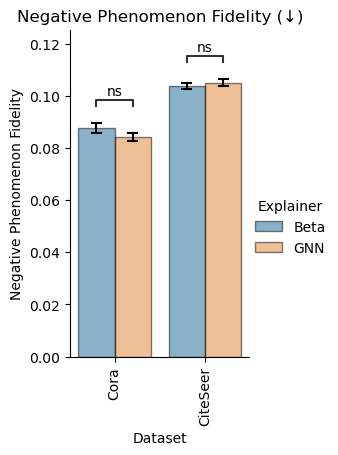

In [22]:
x = 'Dataset'
y = 'Negative Phenomenon Fidelity'
hue = 'Explainer'
hue_order = ['Beta','GNN']
order = ['Cora','CiteSeer']
args = dict(x=x, y=y, data=df_sp_fid, hue=hue, hue_order=hue_order, order=order)
g = sns.catplot(edgecolor="black", errcolor="black", 
                errwidth=1.5, capsize = 0.1, height=4, 
                aspect=.7,alpha=0.5, kind="bar", errorbar = "se",
                **args
               ).set(title='Negative Phenomenon Fidelity (↓)').set_xticklabels(rotation=90)
pairs = [
    (("Cora", "Beta"), ("Cora", "GNN")),
    (("CiteSeer", "Beta"), ("CiteSeer", "GNN"))
]
for ax_n in g.axes:
    for ax in ax_n:
        annot = Annotator(ax, pairs, **args)
        annot.configure(test='Mann-Whitney', loc='inside', verbose=2)
        annot.apply_test().annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CiteSeer_Beta vs. CiteSeer_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=5.000e+01
Cora_Beta vs. Cora_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:1.615e-01 U_stat=6.900e+01


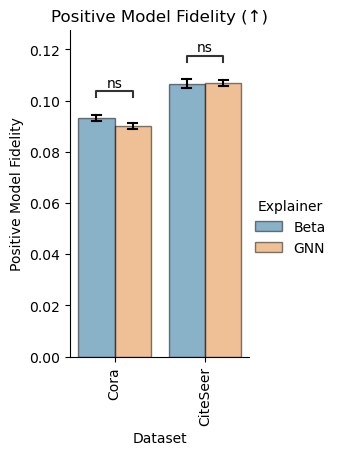

In [23]:
x = 'Dataset'
y = 'Positive Model Fidelity'
hue = 'Explainer'
hue_order = ['Beta','GNN']
order = ['Cora','CiteSeer']
args = dict(x=x, y=y, data=df_sp_fid, hue=hue, hue_order=hue_order, order=order)
g = sns.catplot(edgecolor="black", errcolor="black", 
                errwidth=1.5, capsize = 0.1, height=4, 
                aspect=.7,alpha=0.5, kind="bar", errorbar = "se",
                **args
               ).set(title='Positive Model Fidelity (↑)').set_xticklabels(rotation=90)
pairs = [
    (("Cora", "Beta"), ("Cora", "GNN")),
    (("CiteSeer", "Beta"), ("CiteSeer", "GNN"))
]
for ax_n in g.axes:
    for ax in ax_n:
        annot = Annotator(ax, pairs, **args)
        annot.configure(test='Mann-Whitney', loc='inside', verbose=2)
        annot.apply_test().annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CiteSeer_Beta vs. CiteSeer_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:3.447e-01 U_stat=3.700e+01
Cora_Beta vs. Cora_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:2.727e-01 U_stat=6.500e+01


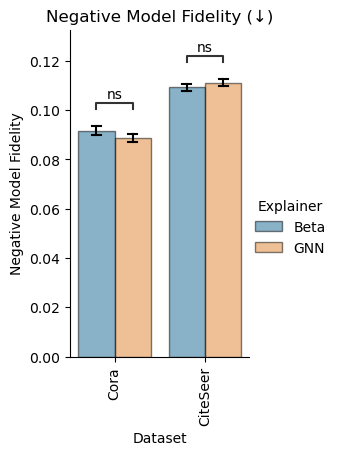

In [24]:
x = 'Dataset'
y = 'Negative Model Fidelity'
hue = 'Explainer'
hue_order = ['Beta','GNN']
order = ['Cora','CiteSeer']
args = dict(x=x, y=y, data=df_sp_fid, hue=hue, hue_order=hue_order, order=order)
g = sns.catplot(edgecolor="black", errcolor="black", 
                errwidth=1.5, capsize = 0.1, height=4, 
                aspect=.7,alpha=0.5, kind="bar", errorbar = "se",
                **args
               ).set(title='Negative Model Fidelity (↓)').set_xticklabels(rotation=90)
pairs = [
    (("Cora", "Beta"), ("Cora", "GNN")),
    (("CiteSeer", "Beta"), ("CiteSeer", "GNN"))
]
for ax_n in g.axes:
    for ax in ax_n:
        annot = Annotator(ax, pairs, **args)
        annot.configure(test='Mann-Whitney', loc='inside', verbose=2)
        annot.apply_test().annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CiteSeer_Beta vs. CiteSeer_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:9.082e-03 U_stat=8.500e+01
Cora_Beta vs. Cora_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:1.817e-04 U_stat=1.000e+02


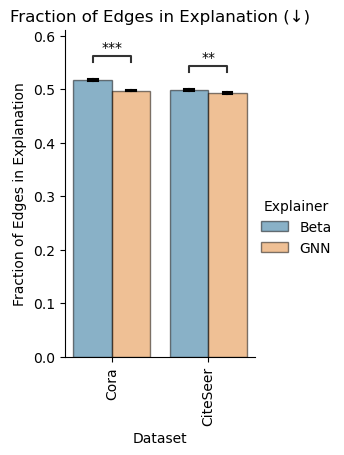

In [25]:
x = 'Dataset'
y = 'Fraction of Edges in Explanation'
hue = 'Explainer'
hue_order = ['Beta','GNN']
order = ['Cora','CiteSeer']
args = dict(x=x, y=y, data=df_sp_fid, hue=hue, hue_order=hue_order, order=order)
g = sns.catplot(edgecolor="black", errcolor="black", 
                errwidth=1.5, capsize = 0.1, height=4, 
                aspect=.7,alpha=0.5, kind="bar", errorbar = "se",
                **args
               ).set(title='Fraction of Edges in Explanation (↓)').set_xticklabels(rotation=90)
pairs = [
    (("Cora", "Beta"), ("Cora", "GNN")),
    (("CiteSeer", "Beta"), ("CiteSeer", "GNN"))
]
for ax_n in g.axes:
    for ax in ax_n:
        annot = Annotator(ax, pairs, **args)
        annot.configure(test='Mann-Whitney', loc='inside', verbose=2)
        annot.apply_test().annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CiteSeer_Beta vs. CiteSeer_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=5.000e+01
Cora_Beta vs. Cora_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=5.000e+01


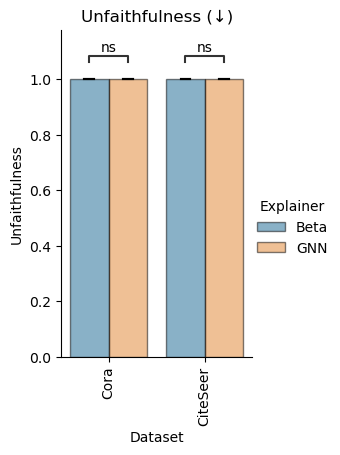

In [26]:
x = 'Dataset'
y = 'Unfaithfulness'
hue = 'Explainer'
hue_order = ['Beta','GNN']
order = ['Cora','CiteSeer']
args = dict(x=x, y=y, data=df_sp_fid, hue=hue, hue_order=hue_order, order=order)
g = sns.catplot(edgecolor="black", errcolor="black", 
                errwidth=1.5, capsize = 0.1, height=4, 
                aspect=.7,alpha=0.5, kind="bar", errorbar = "se",
                **args
               ).set(title='Unfaithfulness (↓)').set_xticklabels(rotation=90)
pairs = [
    (("Cora", "Beta"), ("Cora", "GNN")),
    (("CiteSeer", "Beta"), ("CiteSeer", "GNN"))
]
for ax_n in g.axes:
    for ax in ax_n:
        annot = Annotator(ax, pairs, **args)
        annot.configure(test='Mann-Whitney', loc='inside', verbose=2)
        annot.apply_test().annotate()

In [27]:
np.unique(list(df_xai['Dataset']))

array(['SG-BASE', 'SG-HETEROPHILIC', 'SG-LESSINFORM', 'SG-MOREINFORM',
       'SG-UNFAIR'], dtype='<U15')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SG-HETEROPHILIC_Beta vs. SG-HETEROPHILIC_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:9.103e-01 U_stat=4.720e+02
SG-BASE_Beta vs. SG-BASE_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:4.099e-09 U_stat=8.965e+02
SG-LESSINFORM_Beta vs. SG-LESSINFORM_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:3.000e-01 U_stat=5.545e+02
SG-MOREINFORM_Beta vs. SG-MOREINFORM_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:1.143e-02 U_stat=6.605e+02
SG-UNFAIR_Beta vs. SG-UNFAIR_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:4.051e-01 U_stat=5.400e+02


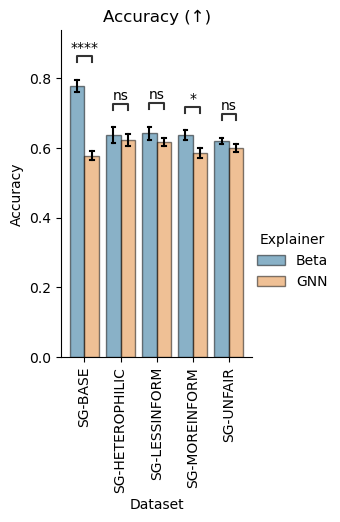

In [28]:
x = 'Dataset'
y = 'Accuracy'
hue = 'Explainer'
hue_order = ['Beta','GNN']
order = ['SG-BASE', 'SG-HETEROPHILIC', 'SG-LESSINFORM', 'SG-MOREINFORM',
       'SG-UNFAIR']
args = dict(x=x, y=y, data=df_xai, hue=hue, hue_order=hue_order, order=order)
g = sns.catplot(edgecolor="black", errcolor="black", 
                errwidth=1.5, capsize = 0.1, height=4, 
                aspect=.7,alpha=0.5, kind="bar", errorbar = "se",
                **args
               ).set(title='Accuracy (↑)').set_xticklabels(rotation=90)
pairs = [
    (("SG-BASE", "Beta"), ("SG-BASE", "GNN")),
    (("SG-HETEROPHILIC", "Beta"), ("SG-HETEROPHILIC", "GNN")),
    (("SG-LESSINFORM", "Beta"), ("SG-LESSINFORM", "GNN")),
    (("SG-MOREINFORM", "Beta"), ("SG-MOREINFORM", "GNN")),
    (("SG-UNFAIR", "Beta"), ("SG-UNFAIR", "GNN")),
]
for ax_n in g.axes:
    for ax in ax_n:
        annot = Annotator(ax, pairs, **args)
        annot.configure(test='Mann-Whitney', loc='inside', verbose=2)
        annot.apply_test().annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SG-HETEROPHILIC_Beta vs. SG-HETEROPHILIC_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:9.215e-01 U_stat=4.730e+02
SG-BASE_Beta vs. SG-BASE_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:4.309e-09 U_stat=8.960e+02
SG-LESSINFORM_Beta vs. SG-LESSINFORM_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:2.779e-01 U_stat=5.580e+02
SG-MOREINFORM_Beta vs. SG-MOREINFORM_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:1.099e-02 U_stat=6.615e+02
SG-UNFAIR_Beta vs. SG-UNFAIR_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:3.973e-01 U_stat=5.410e+02


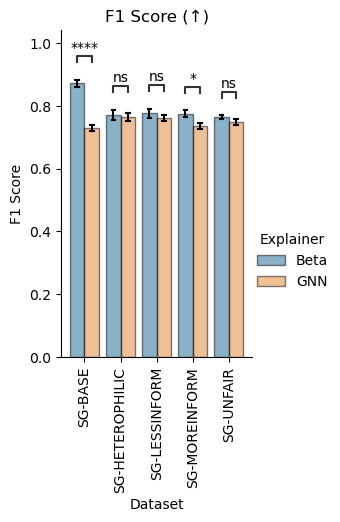

In [29]:
x = 'Dataset'
y = 'F1 Score'
hue = 'Explainer'
hue_order = ['Beta','GNN']
order = ['SG-BASE', 'SG-HETEROPHILIC', 'SG-LESSINFORM', 'SG-MOREINFORM',
       'SG-UNFAIR']
args = dict(x=x, y=y, data=df_xai, hue=hue, hue_order=hue_order, order=order)
g = sns.catplot(edgecolor="black", errcolor="black", 
                errwidth=1.5, capsize = 0.1, height=4, 
                aspect=.7,alpha=0.5, kind="bar", errorbar = "se",
                **args
               ).set(title='F1 Score (↑)').set_xticklabels(rotation=90)
pairs = [
    (("SG-BASE", "Beta"), ("SG-BASE", "GNN")),
    (("SG-HETEROPHILIC", "Beta"), ("SG-HETEROPHILIC", "GNN")),
    (("SG-LESSINFORM", "Beta"), ("SG-LESSINFORM", "GNN")),
    (("SG-MOREINFORM", "Beta"), ("SG-MOREINFORM", "GNN")),
    (("SG-UNFAIR", "Beta"), ("SG-UNFAIR", "GNN")),
]
for ax_n in g.axes:
    for ax in ax_n:
        annot = Annotator(ax, pairs, **args)
        annot.configure(test='Mann-Whitney', loc='inside', verbose=2)
        annot.apply_test().annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SG-HETEROPHILIC_Beta vs. SG-HETEROPHILIC_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:2.895e-05 U_stat=1.830e+02
SG-BASE_Beta vs. SG-BASE_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:1.348e-11 U_stat=1.200e+01
SG-LESSINFORM_Beta vs. SG-LESSINFORM_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:4.872e-02 U_stat=3.400e+02
SG-MOREINFORM_Beta vs. SG-MOREINFORM_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:8.587e-02 U_stat=3.580e+02
SG-UNFAIR_Beta vs. SG-UNFAIR_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:2.830e-11 U_stat=1.000e+01


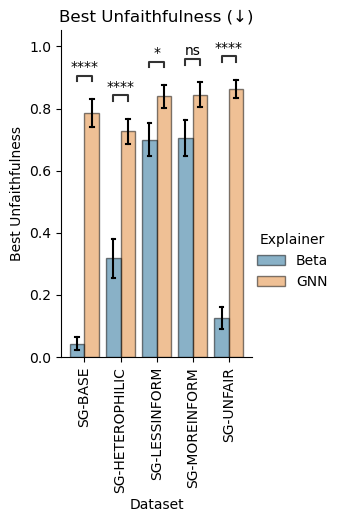

In [30]:
x = 'Dataset'
y = 'Best Unfaithfulness'
hue = 'Explainer'
hue_order = ['Beta','GNN']
order = ['SG-BASE', 'SG-HETEROPHILIC', 'SG-LESSINFORM', 'SG-MOREINFORM',
       'SG-UNFAIR']
args = dict(x=x, y=y, data=df_xai, hue=hue, hue_order=hue_order, order=order)
g = sns.catplot(edgecolor="black", errcolor="black", 
                errwidth=1.5, capsize = 0.1, height=4, 
                aspect=.7,alpha=0.5, kind="bar", errorbar = "se",
                **args
               ).set(title='Best Unfaithfulness (↓)').set_xticklabels(rotation=90)
pairs = [
    (("SG-BASE", "Beta"), ("SG-BASE", "GNN")),
    (("SG-HETEROPHILIC", "Beta"), ("SG-HETEROPHILIC", "GNN")),
    (("SG-LESSINFORM", "Beta"), ("SG-LESSINFORM", "GNN")),
    (("SG-MOREINFORM", "Beta"), ("SG-MOREINFORM", "GNN")),
    (("SG-UNFAIR", "Beta"), ("SG-UNFAIR", "GNN")),
]
for ax_n in g.axes:
    for ax in ax_n:
        annot = Annotator(ax, pairs, **args)
        annot.configure(test='Mann-Whitney', loc='inside', verbose=2)
        annot.apply_test().annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SG-HETEROPHILIC_Beta vs. SG-HETEROPHILIC_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:1.402e-11 U_stat=0.000e+00
SG-BASE_Beta vs. SG-BASE_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:1.402e-11 U_stat=0.000e+00
SG-LESSINFORM_Beta vs. SG-LESSINFORM_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:1.402e-11 U_stat=0.000e+00
SG-MOREINFORM_Beta vs. SG-MOREINFORM_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:1.402e-11 U_stat=0.000e+00
SG-UNFAIR_Beta vs. SG-UNFAIR_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:1.402e-11 U_stat=0.000e+00


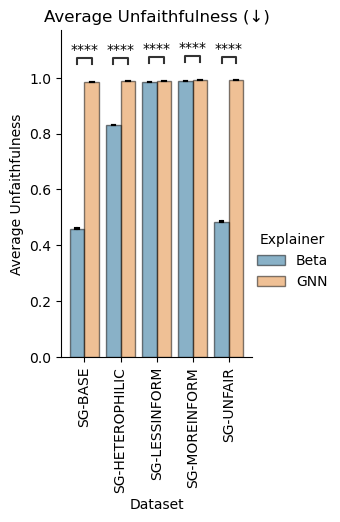

In [31]:
x = 'Dataset'
y = 'Average Unfaithfulness'
hue = 'Explainer'
hue_order = ['Beta','GNN']
order = ['SG-BASE', 'SG-HETEROPHILIC', 'SG-LESSINFORM', 'SG-MOREINFORM',
       'SG-UNFAIR']
args = dict(x=x, y=y, data=df_xai, hue=hue, hue_order=hue_order, order=order)
g = sns.catplot(edgecolor="black", errcolor="black", 
                errwidth=1.5, capsize = 0.1, height=4, 
                aspect=.7,alpha=0.5, kind="bar", errorbar = "se",
                **args
               ).set(title='Average Unfaithfulness (↓)').set_xticklabels(rotation=90)
pairs = [
    (("SG-BASE", "Beta"), ("SG-BASE", "GNN")),
    (("SG-HETEROPHILIC", "Beta"), ("SG-HETEROPHILIC", "GNN")),
    (("SG-LESSINFORM", "Beta"), ("SG-LESSINFORM", "GNN")),
    (("SG-MOREINFORM", "Beta"), ("SG-MOREINFORM", "GNN")),
    (("SG-UNFAIR", "Beta"), ("SG-UNFAIR", "GNN")),
]
for ax_n in g.axes:
    for ax in ax_n:
        annot = Annotator(ax, pairs, **args)
        annot.configure(test='Mann-Whitney', loc='inside', verbose=2)
        annot.apply_test().annotate()